# Qiskit Workshop: graph state fidelity estimation

### Quantum Matters in Materials Science

* Christopher J. Wood (cjwood@us.ibm.com)
* IBM Quantum, T. J. Watson Research Center, Yorktown Heights, USA

## Outline

In this notebook we will demonstrate some examples of noise characterization and error mitigation for near-term quantum computers using the `qiskit-ignis` library applied to state fidelity estimation.

In particular we will demonstrate

* Quantum state tomography
* Measurement error characterization
* Direct fidelity estimation of stabilizer states
* Measurement error mitigation

In [1]:
# Disable python parallelization since it causes issues on my laptop
import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

### Graph state circuit

For an example we will estimate the fidelity of preparing a 4-qubit entangled graph state.

We can generate a graph state circuit using the Qiskit circuit library

In [2]:
import qiskit
from qiskit.circuit.library import GraphState

# 4-qubit graph adjacency matrix
adjmat = [[0, 1, 0, 0],
          [1, 0, 1, 1],
          [0, 1, 0, 0],
          [0, 1, 0, 0]]

# Graph state circuit
state_circuit = GraphState(adjmat)

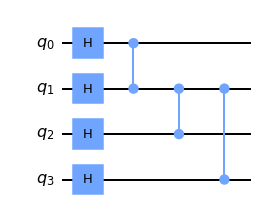

In [3]:
# Plot
state_circuit.draw('mpl')

### Exact output statevector

Next we can compute the exact output state for this circuit by performing a statevector simulation with the `Statevector` class

In [4]:
import qiskit.quantum_info as qi

# Simulate output state of circuit
target_state = qi.Statevector.from_instruction(state_circuit)

print(target_state)

Statevector([ 0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j,
              0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
             -0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
             -0.25+0.j],
            dims=(2, 2, 2, 2))


### Computing state fidelity

When executing the preparation circuit on a real device the gates will have errors that lead to a noisy state $\rho$ being prepared.

We can compare the overall quality of the output state to the ideal target by computing the *quantum state fidelity* 
$$F(\rho, |\psi\rangle) = \langle\psi|\rho|\psi\rangle$$

Note that iff the target state is itself a density matrix $\tau$, the state fidelity is given by
$$F(\rho, \tau) = \mbox{Tr}\left[\sqrt{\sqrt{\tau}\rho\sqrt{\tau}}\right]^2$$

### Adding simulated noise

We can simulate noisy state preparation under a simplified basic device noise model

In [5]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel

# Construct a noise model from saved backend properties of an IBMQ device
backend = FakeVigo()
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'cx', 'u2', 'u3', 'id']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


We can visualize the gate error and readout error parameters used in the noise model

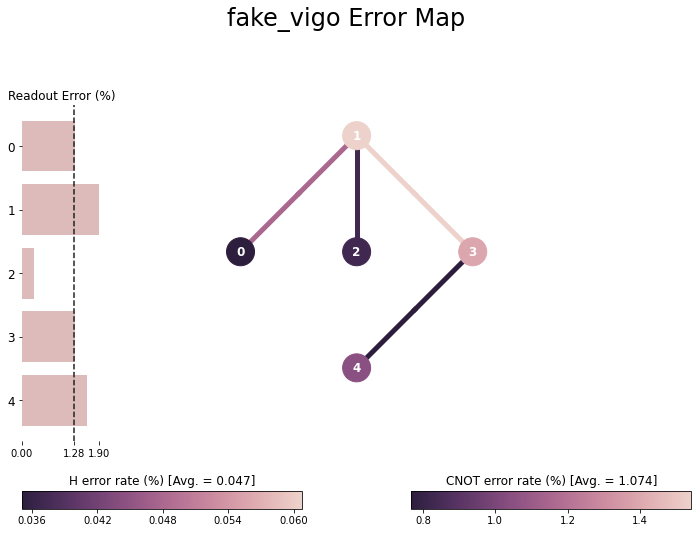

In [6]:
from qiskit.visualization import plot_error_map

plot_error_map(backend)

### Transpiling circuit to basis gates

To simulate the effect of errors we first transpile our circuit into the basis gate of the target device

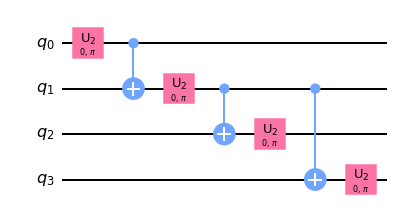

In [7]:
# Transpile circuit for backend
transpiled = qiskit.transpile(state_circuit, basis_gates=noise_model.basis_gates)
transpiled.draw('mpl')

### Inserting quantum errors for simulation

Following this we can insert the error terms into the circuit as non-unitary quantum error instructions

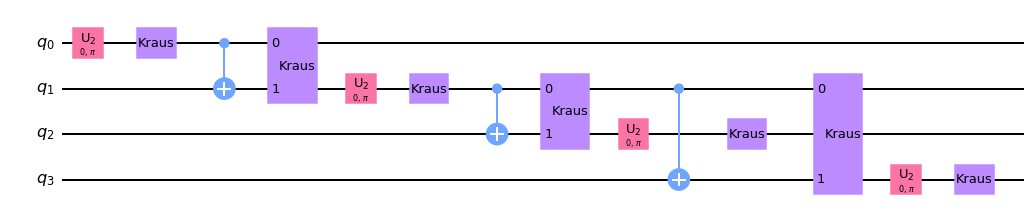

In [8]:
from qiskit.providers.aer.utils import insert_noise

# Insert noise into transpiled circuit
state_circuit_noise = insert_noise(transpiled, noise_model)
state_circuit_noise.draw('mpl')

### Simulating final noisy density matrix

Finally we can use this noisy circuit to compute the output density matrix and $F$ under this noise model

In [9]:
# Compute noisy density matrix
rho_noise = qi.DensityMatrix.from_instruction(state_circuit_noise)

# Compute fideilty of noise density matrix with the ideal state
F = qi.state_fidelity(rho_noise, target_state)

print('F = {:.3f}'.format(F))

F = 0.953


## Experimental fidelity estimation

For a real quantum computer we cannot compute the exact final density matrix so we have to estimate fidelity through a measurement protocol.



### Quantum State Tomography

For general states this is possible using *quantum state tomography*, which is a proceedure for reconstructing an unknown density matrix from noisy measurements. This requires estimating at least $4^n$ probabilities, which can be obtained in $3^n$ Pauli basis measuremens. 

We now demonstrate how to run a quantum state tomography experiment using Qiskit.

This is done using the `tomography` module of `qiskit-ignis`.

In [10]:
import qiskit.ignis.verification.tomography as tomo

# Generate tomography measurement circuits
qubits = [0, 1, 2, 3]
qst_circuits = tomo.state_tomography_circuits(state_circuit, qubits)

Measurement basis: ('X', 'X', 'X', 'X')


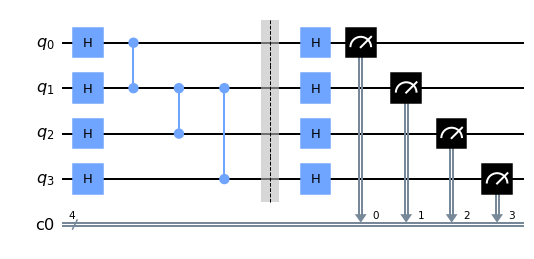

In [11]:
# Example measurement circuit
print('Measurement basis:', qst_circuits[0].name)
qst_circuits[0].draw('mpl')

### Executing the measurement circuits

Next we execute the circuits on a backend. We will use a noisy simulator to mimic a real backend.

In [12]:
from qiskit.providers.aer import QasmSimulator

# Generate mock backend noisy simulator
simulator = QasmSimulator.from_backend(backend)

# Run QST circuits
result_qst = qiskit.execute(qst_circuits, simulator, shots=2048).result()

### Fitting results

To reconstruct the density matrix from the measurement count data we use the Ignis `StateTomographyFitter`

In [13]:
# Fit density matrix
fitter = tomo.StateTomographyFitter(result_qst, qst_circuits)
rho_qst = qi.DensityMatrix(fitter.fit())

In [14]:
# Compute fidelity
F_qst = qi.state_fidelity(rho_qst, target_state)

print('F(QST) = {:.3f}'.format(F_qst))
print('F(Direct Simlated) = {:.3f}'.format(F))

F(QST) = 0.890
F(Direct Simlated) = 0.953


Why is the QST fidelity estimate a lot lower than our simulated value? Because of state preparation and measurement error

### Tomography fit fidelity
Since we simulated the exact output density matrix we can also compute the theoretical *fit fidelity*

This is the state fidelity of the QST density matrix with the noisy simulated density matrix.

In [15]:
F_fit = qi.state_fidelity(rho_qst, rho_noise)

print('F(fit) = {:.3f}'.format(F_fit))

F(fit) = 0.965


## Measurement error

In superconducting qubit systems measurement error is well described by a classical readout error. The true outcome of a measurement $j$ is incorrectly recorded as a value $i$ with probability $P(i|j)$.

We can represent readout error as an *assignment matrix* $$A_{i,j}= P(i|j)$$

Typical values of the largest readout errors for single qubits can be up to 5-10% depending on the device

### Measurement error characterization

Measurement error characterization circuits can be generated using the `mitigation` module of *qiskit-ignis*

In [16]:
import qiskit.ignis.mitigation as mit

# Generate circuits
cal_circuits, metadata = mit.expval_meas_mitigator_circuits(4, method='tensored')

# Run calibration experiment
result_cal = qiskit.execute(cal_circuits, simulator, shots=8192).result()

# Mitigator
mitigator = mit.ExpvalMeasMitigatorFitter(result_cal, metadata).fit()

### Measurement error mitigator

The `mitigator` object (used later to apply error mitigation) stores the assignment matrices for each qubit.

We can extract the marginal single-qubit readout error probabilities from it as follows:

In [17]:
amats_1q = [mitigator.assignment_matrix([i]) for i in range(4)]
probs_meas0given1 = [round(a[0, 1], 3) for a in amats_1q]
probs_meas1given0 = [round(a[1, 0], 3) for a in amats_1q]

print('Single-qubit readout errors\n')
for i in range(4):
    print('Q{}: P(0|1) = {:.3f}, P(1|0) = {:.3f}'.format(
        i, probs_meas0given1[i], probs_meas1given0[i]))

Single-qubit readout errors

Q0: P(0|1) = 0.019, P(1|0) = 0.007
Q1: P(0|1) = 0.030, P(1|0) = 0.008
Q2: P(0|1) = 0.007, P(1|0) = 0.000
Q3: P(0|1) = 0.021, P(1|0) = 0.005


### Mitigating measurement error

We now introduce measurement error mitigation based on the work in [arXiv:2006.14044](https://arxiv.org/abs/2006.14044)

> S. Bravyi, et al. "Mitigating measurement errors in multi-qubit experiments." arXiv:2006.14044 (2020).

This mitigator can be used to apply mitigation to estimations of *expectation values*

### Estimating expectation values

Let $O=\sum_i O_i |i\rangle\!\langle i|$ be a diagonal operator with $|O_i| \le 1$.


The expectation value of $O$ can be estimated by measuring each qubit as
$$\langle O\rangle = \sum_i O_i p_i$$
where $p_i = f_i/M$ is the estimated probability of output $i$ obtained from running $M$ shots.

The error mitigated expectation value can be computed as
$$\langle O\rangle_{\mbox{mit}} = \sum_i\sum_j O_i (A^{-1})_{i,j} p_j $$

To demonstrate this we will measure the expectation value of $XXZX$, one of the *stabilizers* of our graph state

In [18]:
from qiskit.visualization import plot_histogram

# Measure expecation value of XXZX
meas_circuit = state_circuit.copy()
meas_circuit.h([0, 2, 3])
meas_circuit.measure_all()
meas_circuit.draw('mpl')

result_meas = qiskit.execute(meas_circuit, simulator, shots=8192).result()

The resulting probability estimates from this experiment are

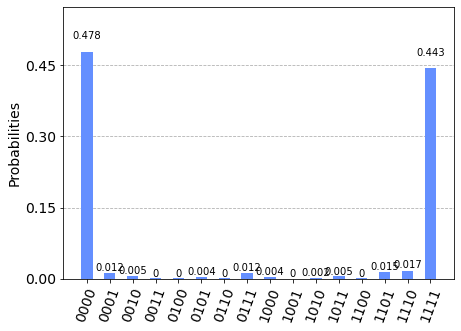

In [19]:
counts = result_meas.get_counts(0)
plot_histogram(counts)

We can compute the expectation value of this operator using the `expectation_value` function in the `mitigation` module

In [20]:
expval, stddev = mit.expectation_value(counts)

print('Measured expectation value') 
print('⟨XXZX⟩ = {:.3f} \u00B1 {:.3f}'.format(expval, stddev))

Measured expectation value
⟨XXZX⟩ = 0.859 ± 0.006


To apply mitigation when computing the expectation value we use the `meas_mitigator` kwarg

In [21]:
expval_mit, stddev_mit = mit.expectation_value(counts, meas_mitigator=mitigator)

print('Readout error mitigated expecation value')
print('⟨XXZX⟩ = {:.3f} \u00B1 {:.3f}'.format(expval_mit, stddev_mit))

Readout error mitigated expecation value
⟨XXZX⟩ = 0.946 ± 0.006


In [22]:
print('Non-mitigated expectation value') 
print('⟨XXZX⟩ = {:.3f} \u00B1 {:.3f}'.format(expval, stddev))

Non-mitigated expectation value
⟨XXZX⟩ = 0.859 ± 0.006


## Direct Fidelity Estimation

Now we demonstrate an another way to experimentally estimate the state fidelity of a graph state through direcet stabilizer measurements.

### Graph state fidelity

Graph states are a type of stabilizer state. An $N$-qubit stabilizer state is uniqely described by the set of $2^N$ stabilizers$[S_i]$ which satisfy $S_i|\psi\rangle = |\psi\rangle$.


The state fidelity of a noisy stabilizer state $\rho$ is given by

$$F = \frac{1}{2^N}\sum_{S_i \in S} \langle S_i \rangle$$

Where $\langle S_i \rangle \equiv Tr[\rho S_i]$ is the expectation value of the stabilizer of the ideal target.

### Computing graph state stabilizers 

Next we compute the stabilizer generators of the graph state by brute force

In [23]:
def compute_stabilizer_group(state):
    """Compute the stabilizer group Paulis and coeffs"""
    labels = []
    for i in qi.pauli_basis(state.num_qubits):
        val = round(qi.state_fidelity(i.to_matrix()[0], state, validate=False))
        if val != 0:
            label = i.to_labels()[0]
            if val == 1:
                label = '+' + label
            else:
                label = '-' + label
            labels.append(label)
    return labels

In [24]:
stabilizers = compute_stabilizer_group(target_state)
print(stabilizers)

['+IIII', '+IIZX', '+IXIX', '+IXZI', '+XIIX', '+XIZI', '+XXII', '+XXZX', '-YYXZ', '-YYYY', '-YZXY', '+YZYZ', '-ZYXY', '+ZYYZ', '+ZZXZ', '+ZZYY']


### Generating stabilzier measurement circuits

We write custom functions to generate stabilzier measurement circuits

In [25]:
def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_circuit(stabilizer, initial_circuit=None):
    """Return a stabilizer measurement cirucits."""
    _, pauli = stabilizer_coeff_pauli(stabilizer)
    if initial_circuit is None:
        circ = qiskit.QuantumCircuit(len(pauli))
    else:
        circ = initial_circuit.copy()
    for i, s in enumerate(reversed(pauli)):
        if s == 'X':
            circ.h(i)
        if s == 'Y':
            circ.sdg(i)
            circ.h(i)
    circ.measure_all()
    return circ

### Running stabilzier measurement circuits

We run our functions to generate the stabilizer measurement circuits and execute on a backend

In [26]:
# Generate stabilizer circuits
stab_circuits = [stabilizer_measure_circuit(s, state_circuit) for s in stabilizers]

# Run stabilizer circuits
result_stab = qiskit.execute(stab_circuits, simulator).result()

### Comuting stabilizer expectation values

Next we compute the expectation values for the stabilizers from the result count data

In [27]:
import numpy as np

def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement."""
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag

def stabilizer_expvals(result, stabilizers, meas_mitigator=None):
    """Compute expectation values from stabilizer measurement results."""
    expvals = []
    stddevs = []
    for i, stab in enumerate(stabilizers):
        expval, stddev = mit.expectation_value(
            result.get_counts(i),
            diagonal=stabilizer_measure_diagonal(stab),
            meas_mitigator=meas_mitigator)
        expvals.append(expval)
        stddevs.append(stddev)
    return np.array(expvals), np.array(stddevs)

In [28]:
def stabilizer_fidelity(expvals, stddevs=None):
    """Compute stabilizer state fidelity from stabilizer expvals."""
    mean = np.mean(expvals)
    if stddevs is None:
        return mean
    stddev = np.sqrt(np.sum(stddevs ** 2))
    return mean, stddev

### Comuting stabilizer expectation values

Next we compute the expectation values for the stabilizers from the result count data

In [29]:
# Compute stabilizer expectation values from data
expvals, stddevs = stabilizer_expvals(result_stab, stabilizers)
F_stab, F_stddev = stabilizer_fidelity(expvals, stddevs)

print('F(direct) = {:.3f} \u00B1 {:.3f}'.format(F_stab, F_stddev))

F(direct) = 0.884 ± 0.058


Applying mitigation improves our fidelity estimate

In [30]:
# Compute stabilizer expectation values from data
expvals_mit, stddevs_mit = stabilizer_expvals(result_stab, stabilizers,
                                      meas_mitigator=mitigator)
F_stab_mit, F_stddev_mit = stabilizer_fidelity(expvals_mit, stddevs_mit)

print('F(mitigated) = {:.3f} \u00B1 {:.3f}'.format(F_stab_mit, F_stddev_mit))

F(mitigated) = 0.950 ± 0.063


In [31]:
import qiskit.tools.jupyter
%qiskit_version_table